## Convolutional Autoencoders

This notebook is an autoencoder for MNIST.  Noise is added to the input, so this autoencoder performs image reconstruction from noisy input.  

Here I included a cell of code to feed predicted output back into the input for many steps.  



In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

2024-06-25 15:28:42.284179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 15:28:42.284235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 15:28:42.285030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 15:28:42.290993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the Dataset

In [2]:
#Load MNIST data from Keras datasets
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train=X_train[0:1000,]  #only need smaller subset to get good results
Y_train=Y_train[0:1000,]

# --------- Reshape input data, b/c Keras expects N-3D images (ie 4D matrix)
X_train = X_train[:,:,:,np.newaxis]
X_test  = X_test[:,:,:,np.newaxis]

#Scale 0 to 1  - or should we not scale
X_train = X_train/255.0
X_test  = X_test/255.0

# Convert 1-dimensional class arrays to 10-dimensional class matrices
#Y_train = keras.utils.to_categorical(Y_train, 10)
#Y_test  = keras.utils.to_categorical(Y_test,  10)

# ------------- End loading and preparing data --------------
print('X train shape:', X_train.shape) 
print('X test shape:', X_test.shape) 


X train shape: (1000, 28, 28, 1)
X test shape: (10000, 28, 28, 1)


In [3]:
#Add some noise to make it harder
def addnoise(X):
    X=X + np.round(np.random.uniform(-1,1,size=X.shape) )
    X[np.where(X>1)]=1
    X[np.where(X<0)]=0
    return X
X_train_wnoise = addnoise(X_train)
X_test_wnoise  = addnoise(X_test)
print('noise added')

noise added


## Define the Model

This will use convolutional layers to build the model. This is composed of three main parts: encoder, bottleneck, and decoder. You will follow the configuration shown in the image below.

The encoder will contract with each additional layer. The features are generated with the Conv2D layers while the max pooling layers reduce the dimensionality.

In [4]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
                                                                     #padding same produces same output size
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1) #max pooling does the downsampling

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2, conv_1, conv_2   #Notice this returns the last layer and intermediate ones

## A bottleneck layer is generally used to get reduce dimensionse and force good representations.

In [5]:
def bottle_neck(inputs):
  '''Defines the bottleneck.''' #how many filters do we need here?
  bottle_neck = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same',name='thebottleneck')(inputs)
    #no maxpooling so no downsampling, 
  
  return bottle_neck

## Add a skip connection with concatenation here 

The decoder will upsample the bottleneck output back to the original image size. 

To add a skip connection, first match up the correct encoding output to the decoding input, so that he feature maps are the same size 

Use the tensorflow concatenation function as described here:

https://keras.io/api/layers/merging_layers/concatenate/

In [6]:
def decoder(inputs, enc_conv1,enc_conv2):
  '''Defines the decoder path to upsample back to the original image size.'''
  #Notice that padding = same keeps the output same size as input 
  
  conv_1      = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  # ---->>>> add concatenate statement to add the encoding layer that matches up_sample_1, either enc_conv1 or enc_conv2
  # ---->>>>     also change the input to conv2 layer, instead of up_sample_1 it should be the concatenated layer
  #skip_concat_1 = tf.keras.layers.Concatenate(axis=-1)([up_sample_1, ____]) 
   
  conv_2      = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  

  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)
    
  #---->>> add another concatenation here to match upsample_2 with an encoding layer output 
  #---->>>    also change the input to conv2 layer
  #skip_concat_2 =

    
  conv_3      = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

You can now build the full autoencoder using the functions above.

Notice that 2 models are actually built; the encoder model is just to v

In [7]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs                                     = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output, enc_conv1_output, enc_conv2_output = encoder(inputs)
  bottleneck_output                          = bottle_neck(encoder_output)
  decoder_output                             = decoder(bottleneck_output, enc_conv1_output, enc_conv2_output)
  
  model         = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  return model



In [8]:
convolutional_model = convolutional_auto_encoder()
convolutional_model.summary() 



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 thebottleneck (Conv2D)      (None, 7, 7, 16)          18448 

2024-06-25 15:28:45.391585: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Compile and Train the model

In [9]:
myES_function = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(X_train_wnoise,X_train, 
                                             validation_data=(X_test_wnoise,X_test),
                                             batch_size=128,
                                             epochs=20,callbacks=[myES_function])


Epoch 1/20
8/8 [==============================] - 5s 544ms/step - loss: 0.5346 - val_loss: 0.4483
Epoch 2/20
8/8 [==============================] - 4s 518ms/step - loss: 0.3825 - val_loss: 0.3088
Epoch 3/20
8/8 [==============================] - 4s 581ms/step - loss: 0.2820 - val_loss: 0.2758
Epoch 4/20
8/8 [==============================] - 4s 559ms/step - loss: 0.2686 - val_loss: 0.2647
Epoch 5/20
8/8 [==============================] - 4s 581ms/step - loss: 0.2575 - val_loss: 0.2512
Epoch 6/20
8/8 [==============================] - 4s 561ms/step - loss: 0.2440 - val_loss: 0.2389
Epoch 7/20
8/8 [==============================] - 4s 499ms/step - loss: 0.2287 - val_loss: 0.2224
Epoch 8/20
8/8 [==============================] - 4s 563ms/step - loss: 0.2146 - val_loss: 0.2129
Epoch 9/20
8/8 [==============================] - 4s 562ms/step - loss: 0.2064 - val_loss: 0.2056
Epoch 10/20
8/8 [==============================] - 4s 519ms/step - loss: 0.1974 - val_loss: 0.1973
Epoch 11/20
8/8 [==

## Display sample results

As usual, let's see some sample results from the trained model.

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')

def display_results(disp_input_images, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  print(' --------------------------------------------------')
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 [==============================] - 0s 99ms/step
 --------------------------------------------------


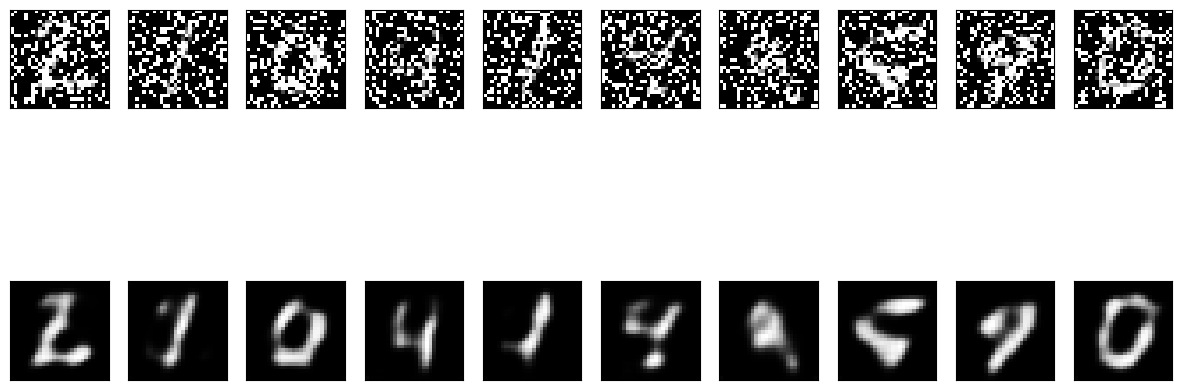

In [11]:
# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
input_test_samples = np.array(X_test_wnoise[idxs])
input_test_samples = np.reshape(input_test_samples, (10, 28, 28, 1))

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(input_test_samples)

# display the samples, encodings and decoded values!
display_results(input_test_samples, predicted, enc_shape=(7,7))

1/1 [==============================] - 0s 25ms/step


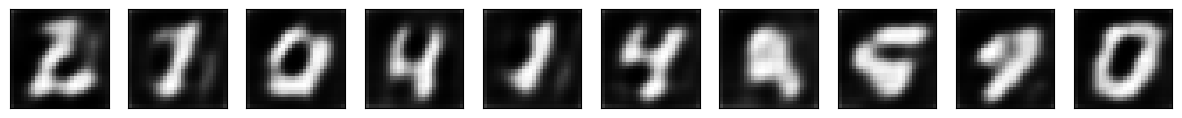

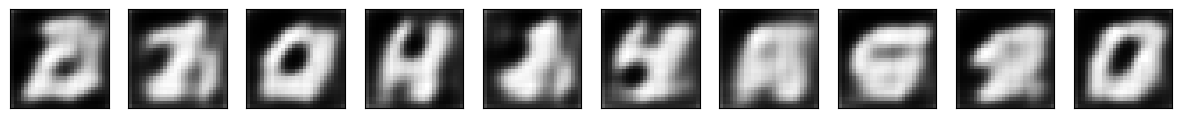

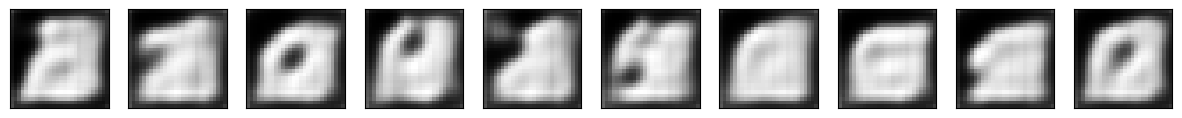

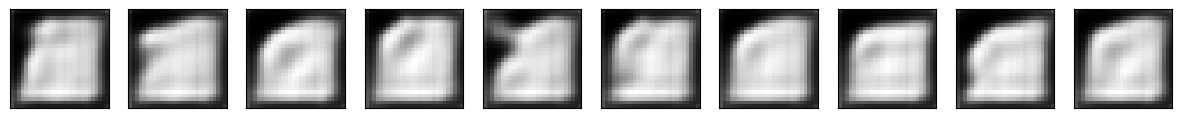

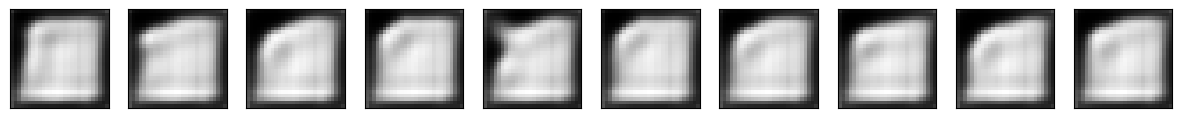

In [12]:
#Try feeding the last predicted output back as input

for i in range(5):
   predicted = convolutional_model.predict(predicted)  #Just feed the 'predicted' output images back as input!
   plt.figure(figsize=(15, 5))
   display_one_row(predicted, 0, shape=(28,28,))
